=== Backtest results with fees ===
Annualized return     : 0.0649
Annualized volatility : 0.0326
Sharpe ratio          : 0.4118
Average diversity     : 0.9300
Constraints met: vol < 25% ? ✅ ; div > 70% ? ✅
Total fees paid       : 780.21 € (0.0780 % of initial capital)


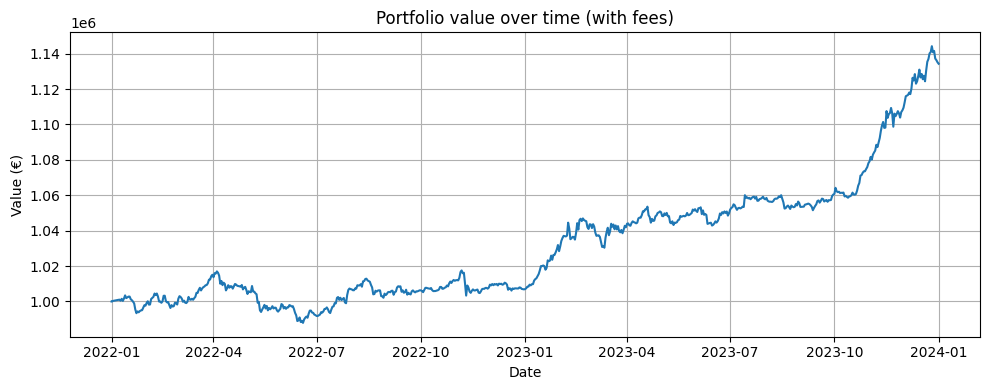


=== Performance summary ===
Annualized return     : 6.49%
Annualized volatility : 3.26%
Sharpe ratio          : 0.4118
Average diversity     : 93.00%
Max drawdown          : -2.86%
Average weights (assets + cash):
[0.00268669 0.00238898 0.00220721 0.00142842 0.00182257 0.00300465
 0.00273851 0.00264984 0.0017701  0.00208797 0.00252255 0.00163325
 0.00146751 0.00123629 0.00220386 0.00186108 0.00364656 0.00179275
 0.00284418 0.00176791 0.95623912]


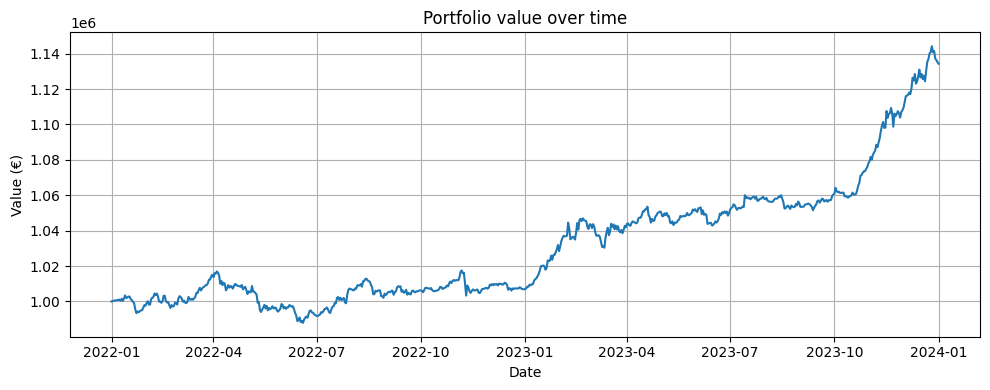

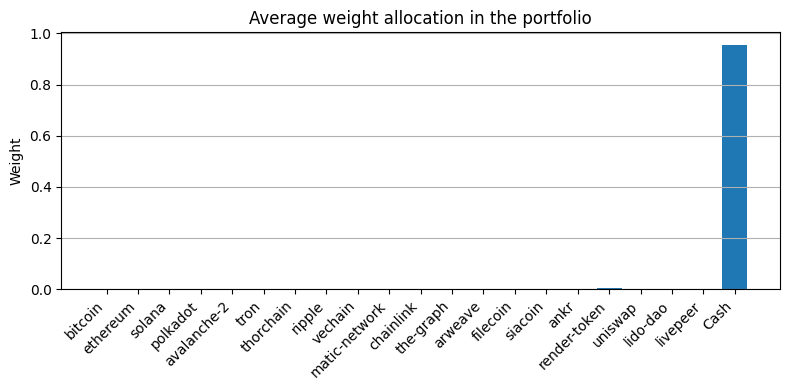

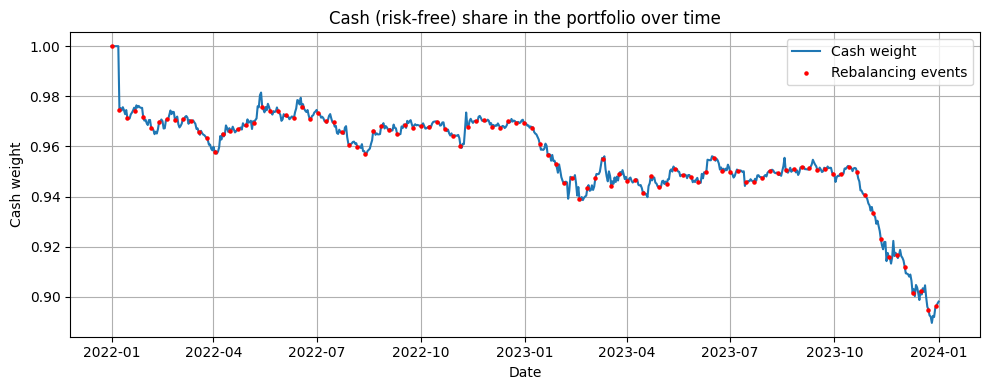

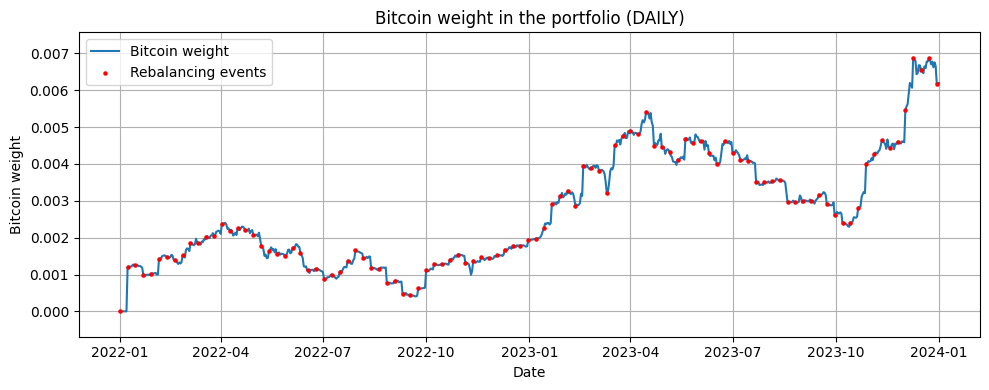

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 0) Constants & globals
risk_free_annual = 0.05
trading_days = 365  # crypto = 365 days/year
risk_free_daily = (1 + risk_free_annual) ** (1 / trading_days) - 1
EPS = 1e-12  # numerical epsilon

# 1) Data loader (semicolon CSV)
def load_prices_semicolon_csv(path="data.csv"):
    df = pd.read_csv(path, sep=";", engine="python")
    if "date" not in df.columns:
        raise ValueError("CSV must have a 'date' column.")
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="raise")
    df = df.set_index("date").sort_index()
    df = df.loc[~df.index.duplicated(keep="last")]

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

# 2) Diversity metric (risky-only)
# D = (sum w)^2 / (n * sum w^2), computed on risky weights only (exclude cash)
# Scale-invariant; returns in [1/n, 1]
def diversity_full(weights):
    w = np.asarray(weights[:-1], dtype=float)  # exclude cash (last element)
    n = len(w)
    if n == 0:
        return 0.0
    denom = np.sum(w**2)
    if denom <= EPS:
        return 0.0
    return (np.sum(w) ** 2) / (n * denom)

# 3) Objective: penalized negative Sharpe
# Uses annual Sharpe with annual vol in denominator
# Penalties if vol > 25% (annual), diversity < 70%, and turnover cost proxy
def neg_sharpe_full(weights, mean_ret, cov, lambda_vol, lambda_div, fee_penalty, prev_weights):
    w = np.asarray(weights[:-1], dtype=float)  # risky
    w_rf = float(weights[-1])                  # cash

    mean_ret = np.asarray(mean_ret, dtype=float)
    cov = np.asarray(cov, dtype=float)

    port_return_daily = float(np.dot(w, mean_ret) + w_rf * risk_free_daily)
    var_daily = float(w.T @ cov @ w)
    var_daily = max(var_daily, 0.0)
    port_vol_daily = np.sqrt(var_daily)

    port_return_annual = port_return_daily * trading_days
    port_vol_annual = port_vol_daily * np.sqrt(trading_days)

    div = diversity_full(weights)

    penalty = 0.0
    if port_vol_annual > 0.25:
        penalty += float(lambda_vol) * (port_vol_annual - 0.25) ** 2
    if div < 0.7:
        penalty += float(lambda_div) * (0.7 - div) ** 2

    estimated_turnover = float(np.sum(np.abs(weights - prev_weights)))
    penalty += float(fee_penalty) * estimated_turnover

    denom = max(port_vol_annual, EPS)
    sharpe = (port_return_annual - risk_free_annual) / denom
    return -sharpe + penalty

# 4) Backtest (fixed params)
def run_backtest_fixed(file_path,
                       window,
                       rebalance_period,
                       lambda_vol,
                       lambda_div,
                       fee_penalty=3.0,
                       start_date=None,
                       end_date=None,
                       plot_ask=True):
    transaction_fee_rate = 0.001
    initial_value = 1_000_000.0

    prices = load_prices_semicolon_csv(file_path)
    returns = prices.pct_change().replace([np.inf, -np.inf], np.nan)

    asset_cols = list(returns.columns)
    n_assets = len(asset_cols)

    if start_date is None:
        start_date = returns.index.min() + pd.Timedelta(days=int(window))
    else:
        start_date = pd.to_datetime(start_date)
    if end_date is None:
        end_date = returns.index.max()
    else:
        end_date = pd.to_datetime(end_date)

    start_backtest = start_date - pd.Timedelta(days=int(window))
    returns = returns.loc[start_backtest:end_date]

    dates_rebalance = [start_date]
    while dates_rebalance[-1] + pd.Timedelta(days=int(rebalance_period)) <= end_date:
        next_target = dates_rebalance[-1] + pd.Timedelta(days=int(rebalance_period))
        valid_dates = returns.index[returns.index >= next_target]
        if len(valid_dates) == 0:
            break
        dates_rebalance.append(valid_dates[0])

    current_value = float(initial_value)
    total_fees = 0.0
    portfolio_values = [current_value]
    portfolio_dates = [start_date]

    current_weights = np.zeros(n_assets + 1, dtype=float)
    current_weights[-1] = 1.0
    position_values = current_weights * current_value
    weights_record = [current_weights.copy()]

    for date in returns.index[returns.index >= start_date]:
        daily_ret = returns.loc[date].reindex(asset_cols).astype(float).fillna(0.0).values
        ret_full = np.append(daily_ret, risk_free_daily)

        position_values *= (1.0 + ret_full)
        current_value = float(np.sum(position_values))
        if current_value <= EPS:
            raise RuntimeError(f"Portfolio value collapsed to ~0 on {date.date()}.")

        current_weights = position_values / current_value

        if date in dates_rebalance:
            pre_rebal_weights_full = current_weights.copy()
            window_start = date - pd.Timedelta(days=int(window))
            data_window = returns.loc[window_start:date - pd.Timedelta(days=1), asset_cols]

            ok_mask = (data_window.count() >= int(0.95 * len(data_window))) & (data_window.std(ddof=1) > 0)
            ok_mask = ok_mask.fillna(False).values
            ok_idx = np.where(ok_mask)[0]
            m = len(ok_idx)

            if m == 0:
                pass
            else:
                sub_window = data_window.iloc[:, ok_idx].dropna(how="any")
                if len(sub_window) == 0:
                    pass
                else:
                    mean_ret = sub_window.mean().values
                    cov = sub_window.cov().values

                    prev_subset = np.zeros(m + 1, dtype=float)
                    prev_subset[:-1] = pre_rebal_weights_full[ok_idx]
                    prev_subset[-1] = pre_rebal_weights_full[-1]

                    x0 = prev_subset.copy()
                    if x0.sum() <= EPS:
                        x0 = np.ones(m + 1, dtype=float)
                    x0 = x0 / np.sum(x0)

                    bounds = [(0.0, 1.0)] * (m + 1)
                    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}

                    res = minimize(
                        neg_sharpe_full,
                        x0,
                        args=(mean_ret, cov, lambda_vol, lambda_div, fee_penalty, prev_subset),
                        bounds=bounds,
                        constraints=cons,
                        method="SLSQP",
                        options={"maxiter": 500, "ftol": 1e-9}
                    )

                    x_star = res.x

                    target_full = np.zeros(n_assets + 1, dtype=float)
                    target_full[ok_idx] = x_star[:-1]
                    target_full[-1] = x_star[-1]

                    s = target_full.sum()
                    if abs(s - 1.0) > 1e-8:
                        target_full = target_full / max(s, EPS)

                    turnover = float(np.sum(np.abs(target_full - pre_rebal_weights_full)))
                    fee = turnover * transaction_fee_rate * current_value

                    cash_value = float(position_values[-1])
                    if fee > cash_value + 1e-6:
                        scale = max((cash_value / fee), 0.0)
                        target_full = pre_rebal_weights_full + scale * (target_full - pre_rebal_weights_full)
                        turnover = float(np.sum(np.abs(target_full - pre_rebal_weights_full)))
                        fee = min(cash_value, turnover * transaction_fee_rate * current_value)

                    position_values[-1] -= fee
                    total_fees += fee
                    current_value = float(np.sum(position_values))

                    position_values = target_full * current_value
                    current_weights = position_values / current_value

        portfolio_values.append(current_value)
        portfolio_dates.append(date)
        weights_record.append(current_weights.copy())

    values = np.asarray(portfolio_values, dtype=float)
    daily_returns = values[1:] / values[:-1] - 1.0
    ann_return = (values[-1] / values[0]) ** (trading_days / max(len(values) - 1, 1)) - 1.0
    ann_vol = float(np.std(daily_returns, ddof=1)) * np.sqrt(trading_days)
    denom = max(ann_vol, EPS)
    sharpe = (float(np.mean(daily_returns)) * trading_days - risk_free_annual) / denom

    mean_weights = np.mean(weights_record, axis=0)
    div = diversity_full(mean_weights)

    peak = np.maximum.accumulate(values)
    drawdown = (values - peak) / peak
    max_drawdown = float(np.min(drawdown))

    if plot_ask:
        print("=== Backtest results with fees ===")
        print(f"Annualized return     : {ann_return:.4f}")
        print(f"Annualized volatility : {ann_vol:.4f}")
        print(f"Sharpe ratio          : {sharpe:.4f}")
        print(f"Average diversity     : {div:.4f}")
        print(f"Constraints met: vol < 25% ? {'✅' if ann_vol < 0.25 else '❌'} ; div > 70% ? {'✅' if div > 0.7 else '❌'}")
        print(f"Total fees paid       : {total_fees:,.2f} € ({100 * total_fees / initial_value:.4f} % of initial capital)")

        plt.figure(figsize=(10, 4))
        plt.plot(portfolio_dates, values)
        plt.title("Portfolio value over time (with fees)")
        plt.xlabel("Date")
        plt.ylabel("Value (€)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'return': ann_return,
        'vol': ann_vol,
        'sharpe': sharpe,
        'diversity': div,
        'weights': mean_weights,
        'values': values,
        'fees_total': total_fees,
        'weights_record': weights_record,
        'dates': portfolio_dates,
        'rebalance_dates': dates_rebalance,
        'max_drawdown': max_drawdown,
        'assets': asset_cols,
    }

# 5) Run with your parameters
file_path = "data.csv"
window = 100
rebalance_period = 7
lambda_vol = 10000
lambda_div = 5000
start_date = "2022-01-01"
end_date = "2024-01-01"

result = run_backtest_fixed(
    file_path=file_path,
    window=window,
    rebalance_period=rebalance_period,
    lambda_vol=lambda_vol,
    lambda_div=lambda_div,
    start_date=start_date,
    fee_penalty=1.1,
    end_date=end_date
)

print("\n=== Performance summary ===")
print(f"Annualized return     : {result['return']:.2%}")
print(f"Annualized volatility : {result['vol']:.2%}")
print(f"Sharpe ratio          : {result['sharpe']:.4f}")
print(f"Average diversity     : {result['diversity']:.2%}")
print(f"Max drawdown          : {result['max_drawdown']:.2%}")
print(f"Average weights (assets + cash):\n{result['weights']}")

# 6) Plots
plt.figure(figsize=(10, 4))
plt.plot(result['dates'], result['values'], label='Portfolio value')
plt.title("Portfolio value over time")
plt.xlabel("Date")
plt.ylabel("Value (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

labels = result['assets'] + ['Cash']
average_weights = result['weights']

plt.figure(figsize=(8, 4))
plt.bar(labels, average_weights)
plt.title("Average weight allocation in the portfolio")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

weights_record = result['weights_record']
dates = result['dates']
rebalance_dates = result['rebalance_dates']

cash_weights = [w[-1] for w in weights_record]
rebalance_idx = [dates.index(d) for d in rebalance_dates if d in dates]

plt.figure(figsize=(10, 4))
plt.plot(dates, cash_weights, linestyle='-', label="Cash weight")
plt.scatter([dates[i] for i in rebalance_idx], [cash_weights[i] for i in rebalance_idx],
            color='red', label='Rebalancing events', zorder=5, s=5)
plt.title("Cash (risk-free) share in the portfolio over time")
plt.xlabel("Date")
plt.ylabel("Cash weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

btc_weights = [w[0] for w in weights_record]
min_btc = min(btc_weights)
max_btc = max(btc_weights)
margin = (max_btc - min_btc) * 0.1 if max_btc != min_btc else 0.01

plt.figure(figsize=(10, 4))
plt.plot(dates, btc_weights, label='Bitcoin weight', linestyle='-')
plt.scatter([dates[i] for i in rebalance_idx], [btc_weights[i] for i in rebalance_idx],
            color='red', label='Rebalancing events', zorder=5, s=5)
plt.title("Bitcoin weight in the portfolio (DAILY)")
plt.xlabel("Date")
plt.ylabel("Bitcoin weight")
plt.ylim(min_btc - margin, max_btc + margin)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()